# Hyperoptimization of WaveNet architecture

In this notebook, we show how to use Deep4Cast to forecast a single time series of Github daily active users. The data can be gathered from [Github Archive](https://www.gharchive.org/) and is entirely public.

The idea of this notebook is to show how to use Deep4Cast to perform model hyperparameter selection.

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from deep4cast.forecasters import Forecaster, VectorScaler
from deep4cast.cv import FoldGenerator, MetricsEvaluator, CrossValidator
import deep4cast.models as models
import deep4cast.utils as utils

from skopt.space import Real, Integer, Categorical

%matplotlib inline

Using TensorFlow backend.


# Parameters

We first specify the parameters for the neural network forecasts, such as number of layers, etc. The architecture we will be using for forecasting is based on WaveNet. The parameters specified here just serve as initialization parameters for the forecaster and will be optimized by the hyperoptimizer.

In [2]:
horizon = 90 # forecasting horizon
lag = 60 # the lookback window is the same as the horizon
filters = 32 # number of convolutional filters per layer in the neural net
num_layers = 1 # the neural network number of layers
lr=0.01
epochs=10
test_fraction = 0.1
n_folds=2

# Data preparation

The data set consists of only one time series, Github daily active users, that we want to model. In addition, we build a few dummy variables for holidays and such below.

In [3]:
if not os.path.isfile('data/processed/github_dau_2011-2018.pkl'):
    # if the data doesn't exist then run the processing script
    %run data/process_github.py --data_path data/raw/github_dau_2011-2018.csv --output_path data/processed/github_dau_2011-2018.pkl
# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('data/processed/github_dau_2011-2018.pkl')
data = df.drop(['month', 'day', 'age'], axis=1)
data = data.dropna()

In [4]:
# Log transform targets
data['count'] = np.log1p(data['count'])

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['count']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past seasonal behavior
lagged = data[real_values].shift(365-horizon)
lagged = lagged.rename(columns={column:column + '_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Recalculate training & testing boundary
test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]

# Create a numpy array drop date columns
data_arr = data.drop(['date'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

/home/austin/miniconda3/envs/d4c-keras/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


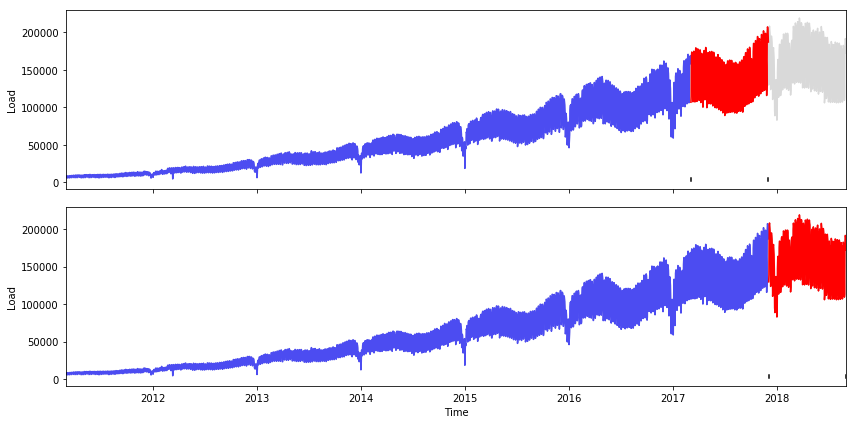

In [5]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds, ncols=1, sharex=True, figsize=(12, 6))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.date[:i*test_length+train_length]
    y_train = df['count'][:i*test_length+train_length]
    x_test = df.date[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df['count'][i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.date
    y_all = df['count']
    
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    #ax.set_ylim([2000, 5500])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

# Model
The network architecture used in this example is based on WaveNet. We also need to build objects that handle data preparation and evaluation.

In [6]:
# Forecaster and model setup
input_shape = (lag, data_arr.shape[2])
output_shape = (horizon, 2)
model = models.WaveNet(input_shape, output_shape, filters=filters, num_layers=num_layers)
forecaster = Forecaster(model, lr=lr, epochs=epochs)

# Fold generator
fold_generator = FoldGenerator(
    data=data_arr, 
    targets=[0], 
    lag=lag, 
    horizon=horizon, 
    test_fraction=test_fraction, 
    n_folds=n_folds
)

# Evaluator for evaluating a few metrics
evaluator = MetricsEvaluator(metrics = ['smape', 'pinball_loss', 'coverage'])

# A data scaler is needed to bring normalize the data before fitting the model
scaler = VectorScaler(targets = [0, -1])

# Cross-validator brings all components together
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

# Optimization

Now that we have our optimization environment set up we need to specifiy the parameter space over which we would like to optimize the hyperparameters of our machine learning model. We use scikit-optimize for this, which uses a Gaussian Process-based Bayesian optimization algorthim to find a good set of hyperparameters

In [7]:
# Set up the parameter space that we would like to optimize over
space  = [Integer(32, 512, name='filters'),
          Integer(1, 4, name='num_layers'),
          Integer(1, 200, name='epochs'),
          Real(10**-6, 10**-4, "log-uniform", name='lr')]

# Oprimize the heck out of this
opt_results = validator.optimize(space, 'smape', n_calls=50)

{'filters': 317, 'num_layers': 4, 'epochs': 172, 'lr': 4.9488407363757504e-05}
0.565
{'filters': 331, 'num_layers': 2, 'epochs': 60, 'lr': 1.298452164375177e-06}
0.475
{'filters': 163, 'num_layers': 2, 'epochs': 163, 'lr': 9.119149691664944e-06}
0.415
{'filters': 221, 'num_layers': 4, 'epochs': 68, 'lr': 1.9785350310947e-05}
0.395
{'filters': 209, 'num_layers': 4, 'epochs': 29, 'lr': 5.497617455119919e-05}
0.405
{'filters': 259, 'num_layers': 3, 'epochs': 105, 'lr': 2.2790773248734106e-05}
0.385
{'filters': 378, 'num_layers': 3, 'epochs': 108, 'lr': 3.290267810262659e-05}
0.39
{'filters': 83, 'num_layers': 2, 'epochs': 38, 'lr': 2.9773943113019397e-05}
0.365
{'filters': 136, 'num_layers': 1, 'epochs': 66, 'lr': 1.992277060218844e-06}
0.36
{'filters': 139, 'num_layers': 2, 'epochs': 181, 'lr': 7.941453180482805e-06}
0.365
{'filters': 32, 'num_layers': 4, 'epochs': 6, 'lr': 1.53898004951627e-06}
0.4
{'filters': 119, 'num_layers': 2, 'epochs': 119, 'lr': 2.5093889768481196e-06}
0.35
{'fil

{'filters': 32, 'num_layers': 1, 'epochs': 1, 'lr': 0.0001}
0.33499999999999996
{'filters': 400, 'num_layers': 4, 'epochs': 200, 'lr': 1e-06}
0.33999999999999997
{'filters': 399, 'num_layers': 1, 'epochs': 200, 'lr': 1e-06}
0.33999999999999997
{'filters': 32, 'num_layers': 1, 'epochs': 200, 'lr': 1e-06}
0.345


{'filters': 32, 'num_layers': 1, 'epochs': 200, 'lr': 1e-06}
0.345
{'filters': 512, 'num_layers': 4, 'epochs': 200, 'lr': 1e-06}
